<a href="https://colab.research.google.com/github/Sowpnil-Roy/Exercise-Monitoring-Thesis/blob/main/Exercise_monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
# Downgrade scipy to a version compatible with scikit-plot
!pip install imbalanced-learn scikit-plot "scipy<1.11.0" -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

import joblib


In [ ]:
# Upload file to Colab
from google.colab import files
uploaded = files.upload()

# Load dataset
df = pd.read_csv('Exercisemonitoring.csv', na_values=["#DIV/0!", ""])

# Display dataset info
print(f"Dataset shape: {df.shape}")
df.info()

Saving Exercisemonitoring.csv to Exercisemonitoring (2).csv
Dataset shape: (39242, 159)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39242 entries, 0 to 39241
Columns: 159 entries, user_name to classe
dtypes: float64(132), int64(23), object(4)
memory usage: 47.6+ MB


In [ ]:
# Drop irrelevant columns
irrelevant_cols = ['user_name', 'raw_timestamp_part_1', 'raw_timestamp_part_2',
                  'cvtd_timestamp', 'new_window', 'num_window']
df_clean = df.drop(columns=irrelevant_cols, errors='ignore')

In [ ]:
# Handle missing values
print(f"Missing values before: {df_clean.isnull().sum().sum()}")
threshold = len(df) * 0.6  # Keep columns with at least 60% non-missing values
df_clean = df_clean.dropna(thresh=threshold, axis=1)



Missing values before: 1


In [ ]:
# 3. Handle near-zero variance columns
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
X = df_clean.drop('classe', axis=1)
X_selected = selector.fit_transform(X)


In [ ]:
# Get selected feature names
mask = selector.get_support()
selected_features = X.columns[mask]
df_features = pd.DataFrame(X_selected, columns=selected_features)

In [ ]:
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (39242, 159)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39242 entries, 0 to 39241
Columns: 159 entries, user_name to classe
dtypes: float64(132), int64(23), object(4)
memory usage: 47.6+ MB


In [ ]:
# Handle missing values
print(f"Missing values before: {df_clean.isnull().sum().sum()}")
threshold = len(df) * 0.6  # Keep columns with at least 60% non-missing values
df_clean = df_clean.dropna(thresh=threshold, axis=1)

# Add an imputation step here
from sklearn.impute import SimpleImputer

# Separate features (X) and target (y) before imputation
X = df_clean.drop('classe', axis=1)
y = df_clean['classe']

# Initialize and fit the imputer
imputer = SimpleImputer(strategy='mean') # Or 'median' depending on data distribution
X_imputed = imputer.fit_transform(X)

# Convert the imputed data back to a DataFrame to keep column names
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

# 3. Handle near-zero variance columns
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
# Use the imputed data for variance thresholding
X_selected = selector.fit_transform(X_imputed_df)

# Get selected feature names
mask = selector.get_support()
# Ensure selected features are based on the columns from X_imputed_df
selected_features = X_imputed_df.columns[mask]
df_features = pd.DataFrame(X_selected, columns=selected_features)

print(f"Dataset shape after imputation and variance threshold: {df_features.shape}")
# Check for any remaining missing values after imputation (should be none)
print(f"Missing values after imputation: {df_features.isnull().sum().sum()}")

# 4. Encode target variable
le = LabelEncoder()
# Use the original target variable before imputation, as y was separated earlier
y_encoded = le.fit_transform(y)

# 5. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# 6. Handle class imbalance (if needed)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
# Use the scaled features and encoded target for SMOTE
X_res, y_res = smote.fit_resample(X_scaled, y_encoded)

print(f"Shape after SMOTE: X_res = {X_res.shape}, y_res = {y_res.shape}")

Missing values before: 1
Dataset shape after imputation and variance threshold: (39242, 51)
Missing values after imputation: 0
Shape after SMOTE: X_res = (55795, 51), y_res = (55795,)


In [ ]:
# 1. Correlation analysis
corr_matrix = pd.DataFrame(X_scaled, columns=selected_features).corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
X_final = pd.DataFrame(X_scaled, columns=selected_features).drop(columns=to_drop)

# 2. PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X_final)
print(f"Reduced from {X_final.shape[1]} to {pca.n_components_} features")

Reduced from 47 to 25 features


In [ ]:
# 1. Correlation analysis (applied before SMOTE, as it doesn't change sample size)
corr_matrix = pd.DataFrame(X_scaled, columns=selected_features).corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
X_final = pd.DataFrame(X_scaled, columns=selected_features).drop(columns=to_drop)

# 2. Handle class imbalance (if needed) - Moved this section up
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
# Use X_final (after correlation analysis and scaling) and y_encoded for SMOTE
X_res, y_res = smote.fit_resample(X_final, y_encoded)

print(f"Shape after SMOTE: X_res = {X_res.shape}, y_res = {y_res.shape}")

# 3. PCA for dimensionality reduction (applied after SMOTE)
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
# Apply PCA to the oversampled features
X_pca = pca.fit_transform(X_res)
print(f"Reduced from {X_res.shape[1]} to {pca.n_components_} features after SMOTE")


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data
# Now X_pca and y_res should have the same number of samples (55795)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_res, test_size=0.2, random_state=42
)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5),
    "SVM": SVC(C=1.0, kernel='rbf', probability=True)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[name] = {
        "model": model,
        "accuracy": acc,
        "report": report,
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"Classification Report:\n{report}\n")

# Identify best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
print(f"Best Model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")

Shape after SMOTE: X_res = (55795, 47), y_res = (55795,)
Reduced from 47 to 25 features after SMOTE
Random Forest Accuracy: 0.8897
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      2212
           1       0.93      0.86      0.90      2213
           2       0.75      0.96      0.84      2234
           3       0.88      0.87      0.87      2245
           4       1.00      0.90      0.94      2255

    accuracy                           0.89     11159
   macro avg       0.90      0.89      0.89     11159
weighted avg       0.90      0.89      0.89     11159


Gradient Boosting Accuracy: 0.9768
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2212
           1       0.97      0.97      0.97      2213
           2       0.95      0.98      0.97      2234
           3       0.98      0.98      0.98      2245
           4       1.00    


Training Random Forest...
Random Forest Accuracy: 0.8897
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      2212
           1       0.93      0.86      0.90      2213
           2       0.75      0.96      0.84      2234
           3       0.88      0.87      0.87      2245
           4       1.00      0.90      0.94      2255

    accuracy                           0.89     11159
   macro avg       0.90      0.89      0.89     11159
weighted avg       0.90      0.89      0.89     11159


Training Gradient Boosting...
Gradient Boosting Accuracy: 0.9778
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2212
           1       0.98      0.97      0.97      2213
           2       0.95      0.99      0.97      2234
           3       0.98      0.98      0.98      2245
           4       1.00      0.98      0.99      2255

    accuracy                           0.98     11159
   macr

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:51:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9830
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2212
           1       0.99      0.97      0.98      2213
           2       0.96      0.98      0.97      2234
           3       0.98      0.98      0.98      2245
           4       1.00      0.99      1.00      2255

    accuracy                           0.98     11159
   macro avg       0.98      0.98      0.98     11159
weighted avg       0.98      0.98      0.98     11159

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4736 - loss: 1.2640 - val_accuracy: 0.7784 - val_loss: 0.6690
Epoch 2/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7260 - loss: 0.7222 - val_accuracy: 0.8640 - val_loss: 0.4650
Epoch 3/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7935 - loss: 0.5505 - val_accuracy: 0.8910 - val_loss: 0.3738
Epoch 4/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8313 - loss: 0.4523 - val_accuracy: 0.9094 - val_loss: 0.3171
Epoch 5/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8545 - loss: 0.3900 - val_accuracy: 0.9239 - val_loss: 0.2870
Epoch 6/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8662 - loss: 0.3546 - val_accuracy: 0.9336 - val_loss: 0.2654
Epoch 7/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8769 - loss: 0.3295 - val_accuracy: 0.9404 - val_loss: 0.2429
Epoch 8/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8929 - loss: 0.2974 - val_accuracy: 0.9427 - val_

<ipython-input-30-3443658959>:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=model_comparison, palette='viridis')


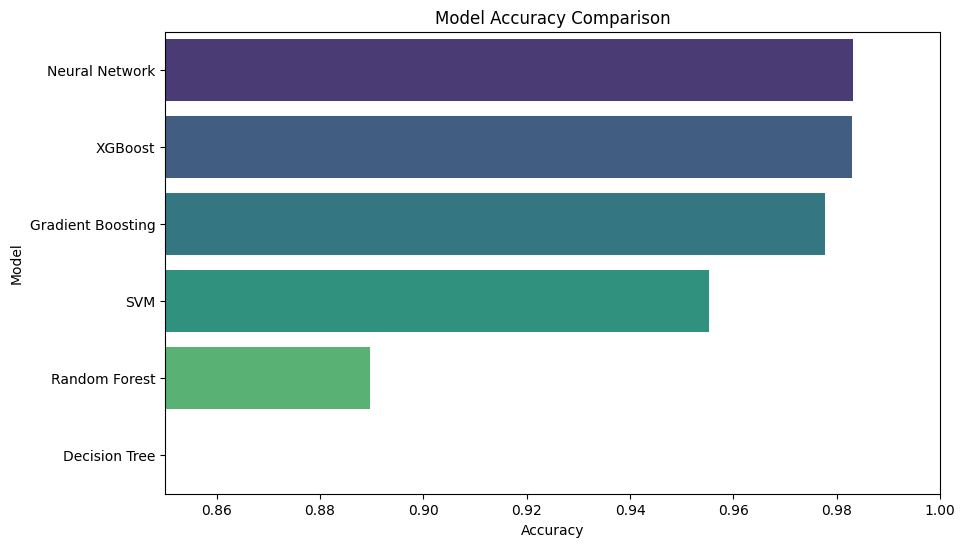

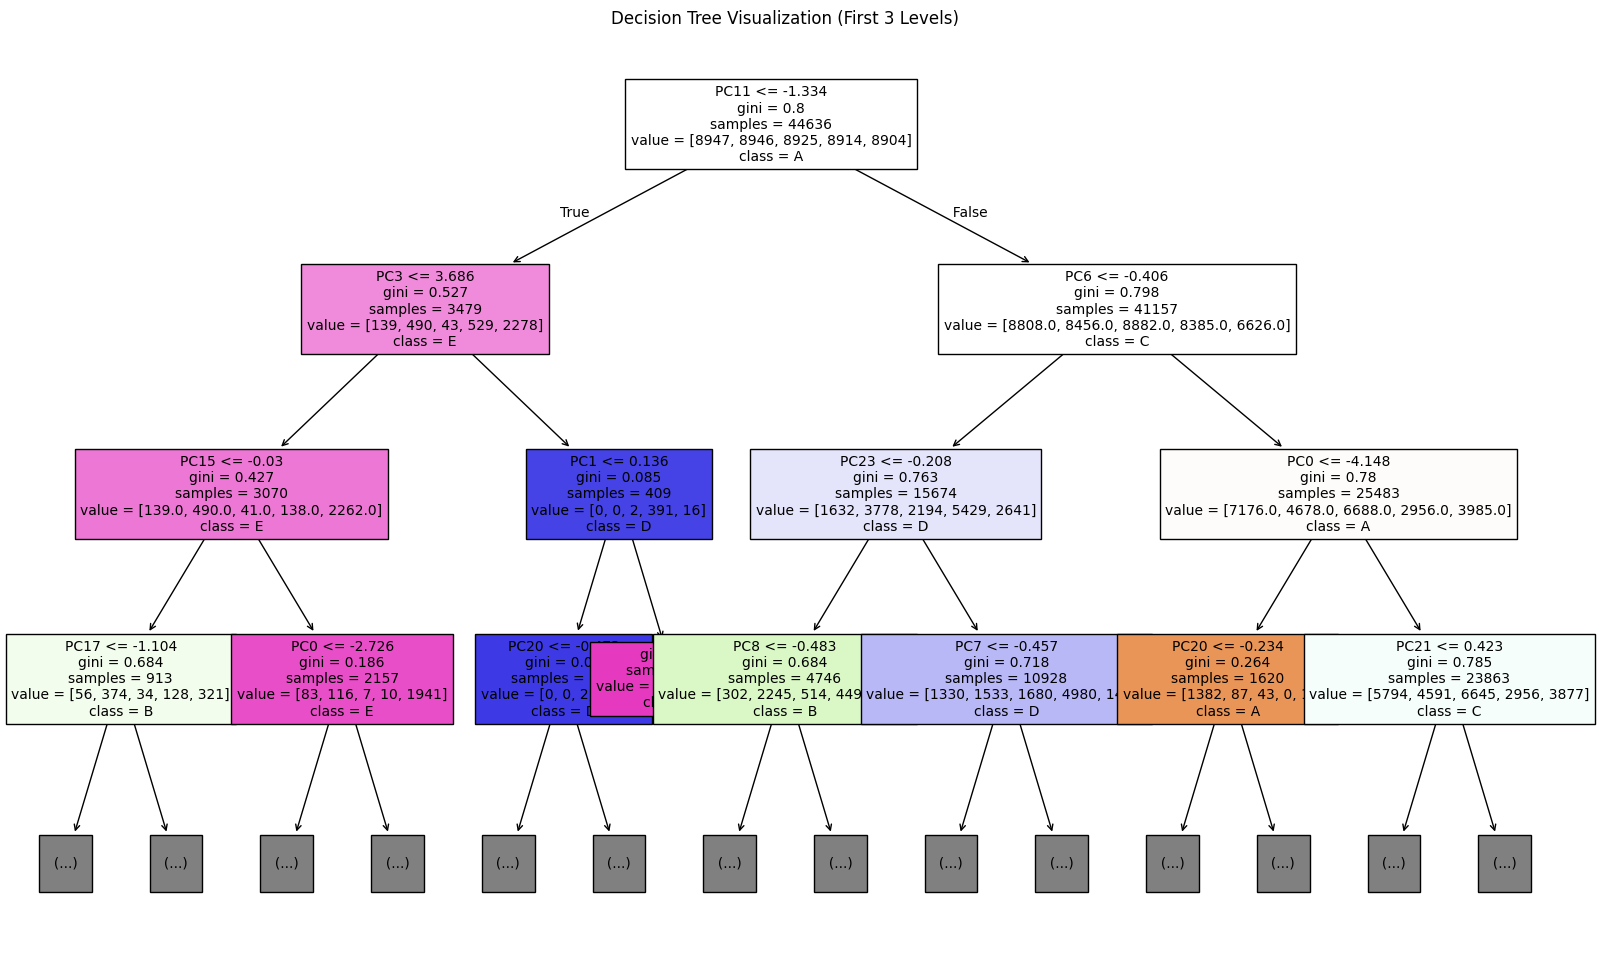

NameError: name 'skplt' is not defined

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
#import scikitplot as skplt
import joblib
import cv2
# Step 3: Load and preprocess data (same as before)
# [Use your existing data loading and preprocessing code]

# Step 4: Enhanced Model Training
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_res, test_size=0.2, random_state=42
)

# Initialize additional models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5),
    "SVM": SVC(C=1.0, kernel='rbf', probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=8, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='mlogloss')
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "model": model,
        "accuracy": acc,
        "report": classification_report(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

# Step 5: Neural Network Model
# Convert labels to one-hot encoding
num_classes = len(le.classes_)
y_train_oh = to_categorical(y_train, num_classes)
y_test_oh = to_categorical(y_test, num_classes)

# Build neural network
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_pca.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

nn_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train neural network
history = nn_model.fit(X_train, y_train_oh,
                       epochs=50,
                       batch_size=64,
                       validation_split=0.2,
                       verbose=1)

# Evaluate neural network
nn_acc = nn_model.evaluate(X_test, y_test_oh, verbose=0)[1]
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)
results["Neural Network"] = {
    "model": nn_model,
    "accuracy": nn_acc,
    "report": classification_report(y_test, y_pred_nn),
    "conf_matrix": confusion_matrix(y_test, y_pred_nn)
}

print(f"\nNeural Network Accuracy: {nn_acc:.4f}")
print(classification_report(y_test, y_pred_nn))

# Step 6: Model Comparison
# Create comparison table
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results]
}).sort_values('Accuracy', ascending=False)

print("\nModel Comparison:")
print(model_comparison)

# Visualize accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=model_comparison, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlim(0.85, 1.0)
plt.show()

# Step 7: Visualize Decision Tree
plt.figure(figsize=(20, 12))
plot_tree(models['Decision Tree'],
          filled=True,
          feature_names=[f"PC{i}" for i in range(X_pca.shape[1])],
          class_names=le.classes_,
          max_depth=3,  # Show first 3 levels for readability
          fontsize=10)
plt.title('Decision Tree Visualization (First 3 Levels)')
plt.show()

# Step 8: Confusion Matrix for Best Model
best_model_name = model_comparison.iloc[0]['Model']
best_result = results[best_model_name]

skplt.metrics.plot_confusion_matrix(
    y_test,
    best_result['model'].predict(X_test) if best_model_name != "Neural Network" else y_pred_nn,
    figsize=(10, 8),
    title=f'Confusion Matrix ({best_model_name})',
    normalize=True,
    text_fontsize='large'
)
plt.show()

# Step 9: Learning Curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
!pip install --upgrade scikit-plot

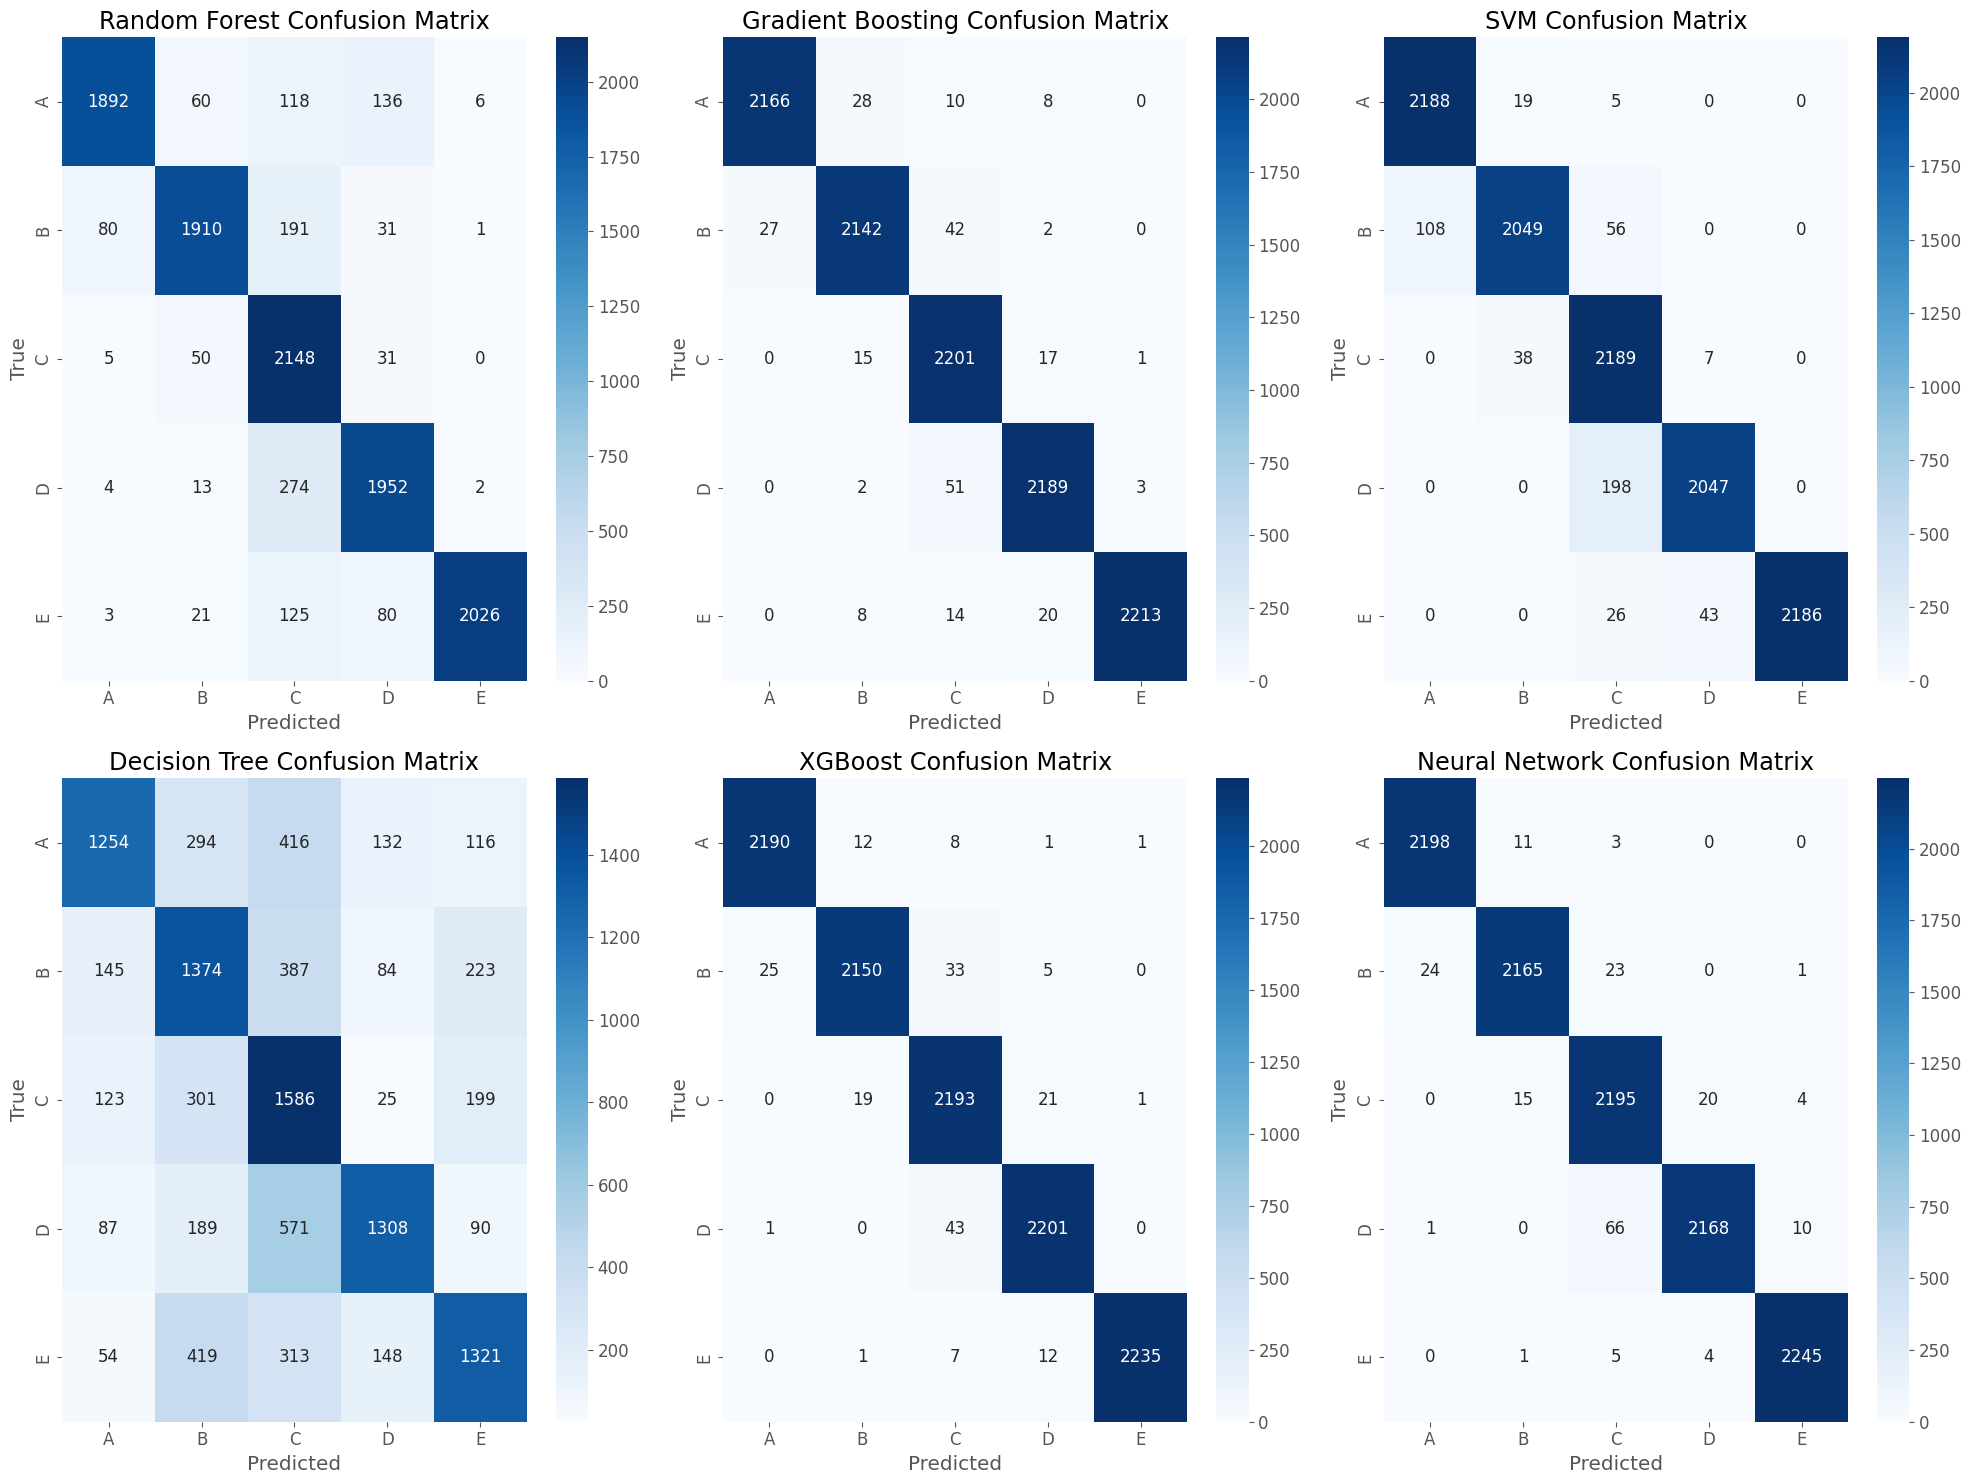

349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


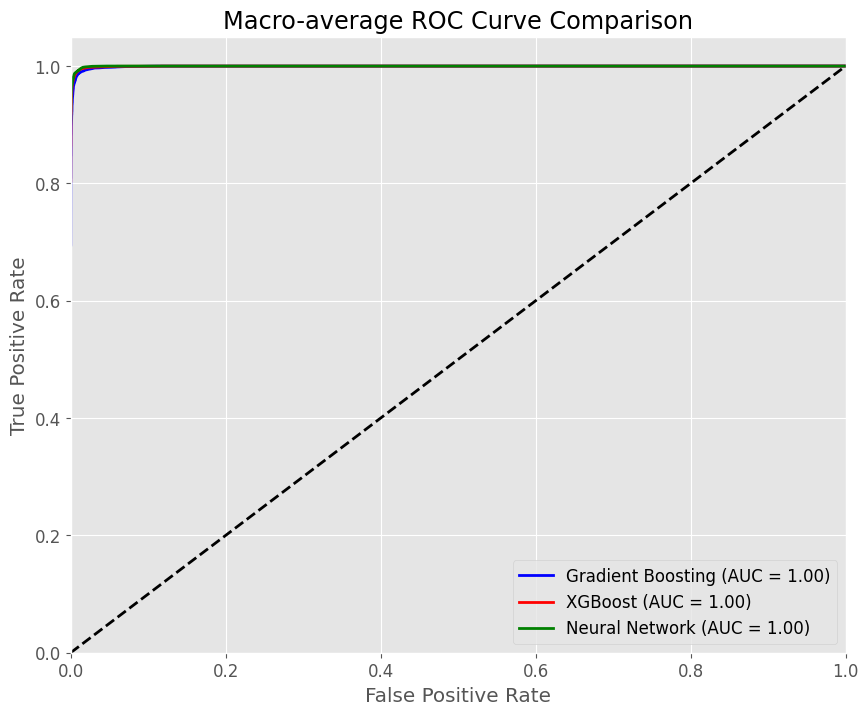

349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


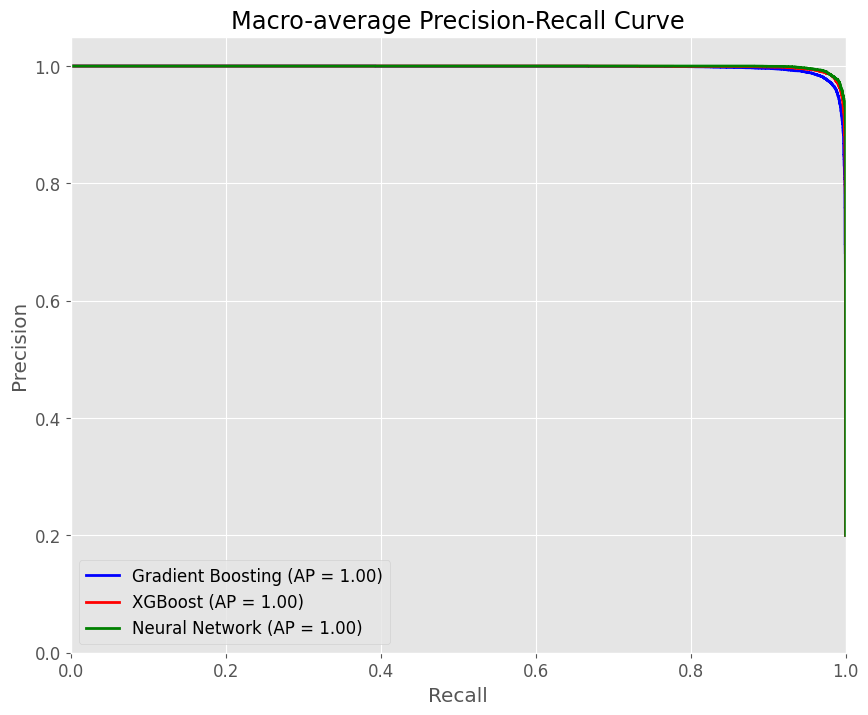

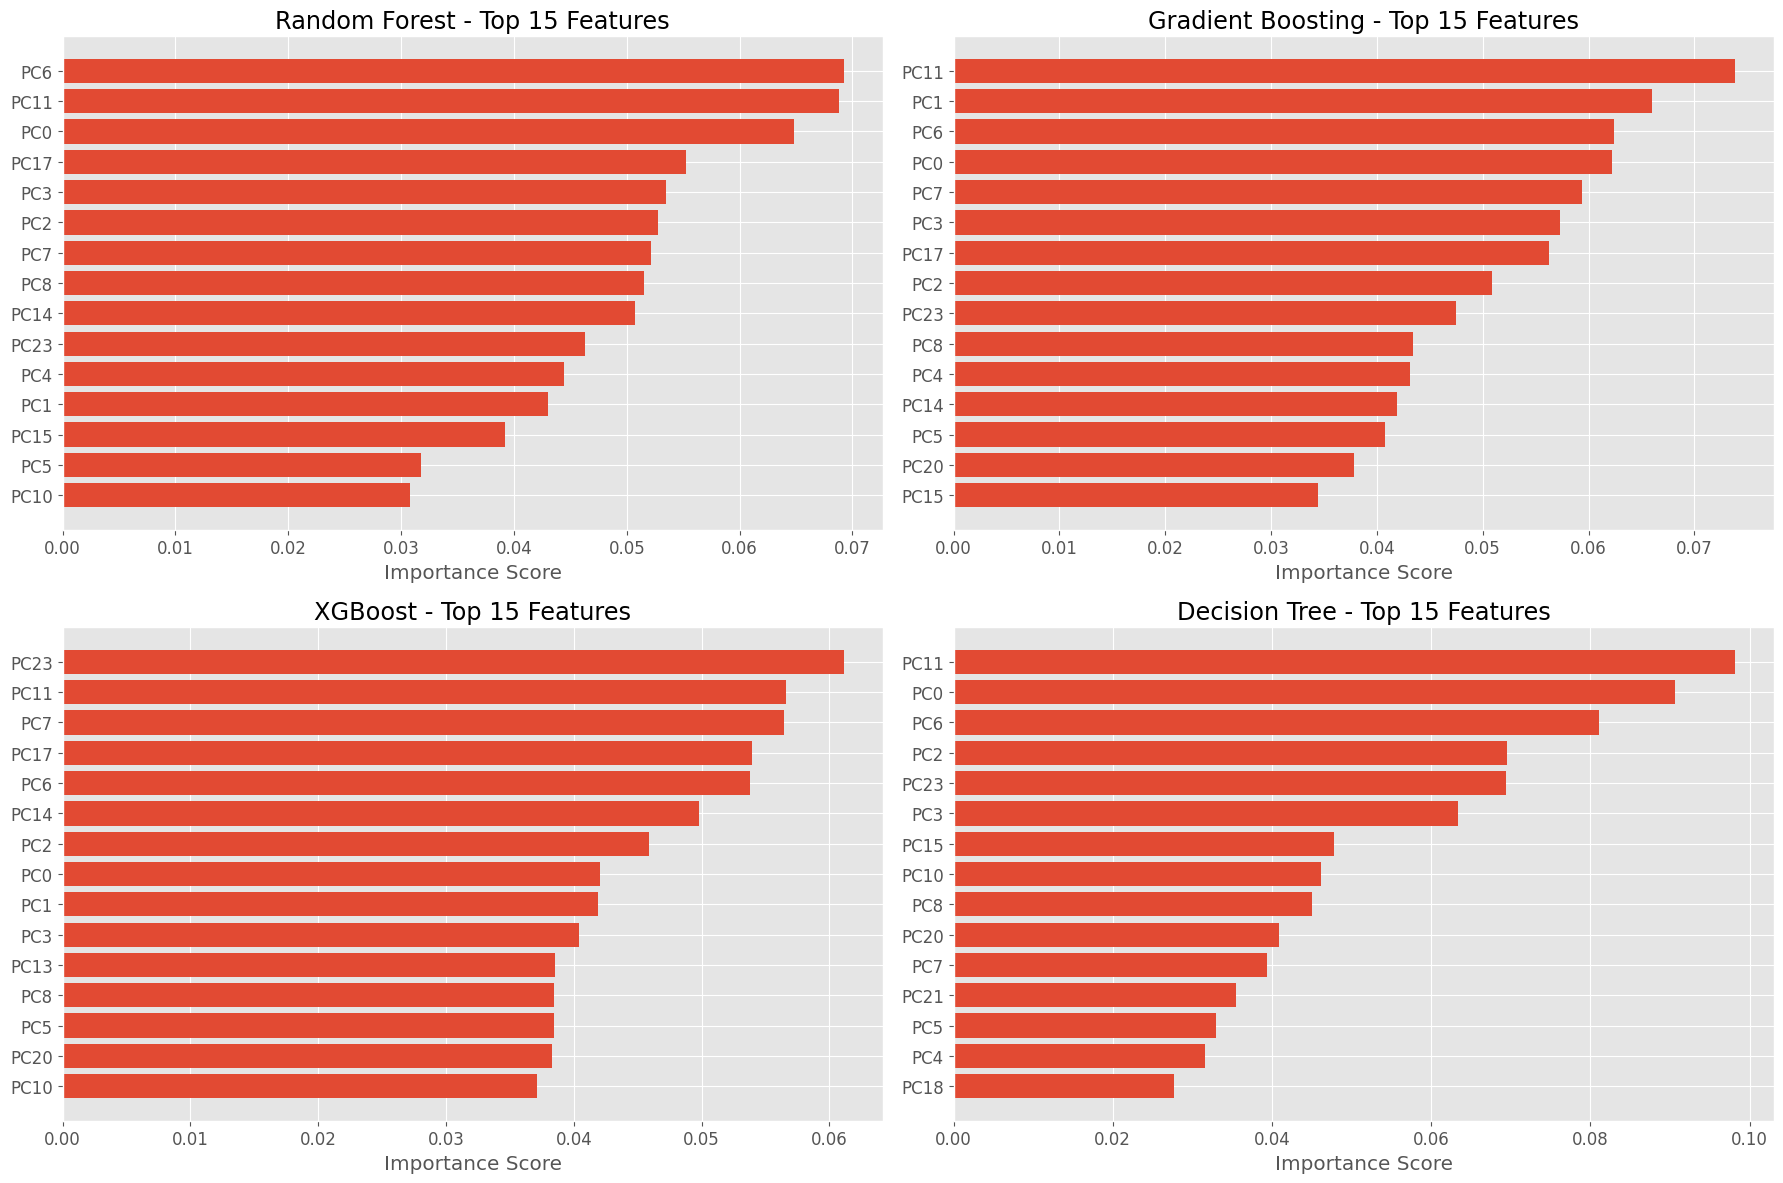

349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


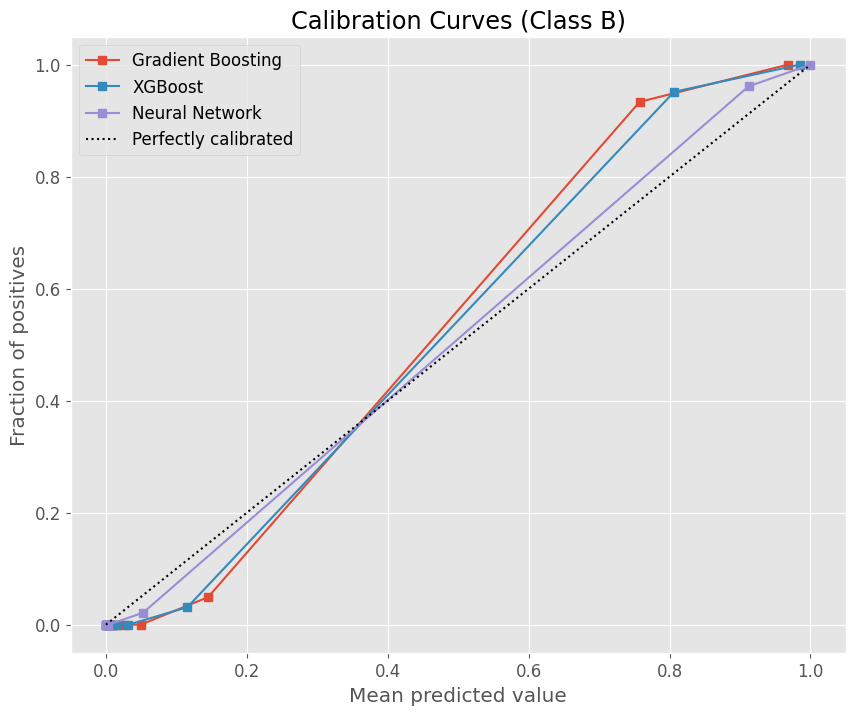

349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


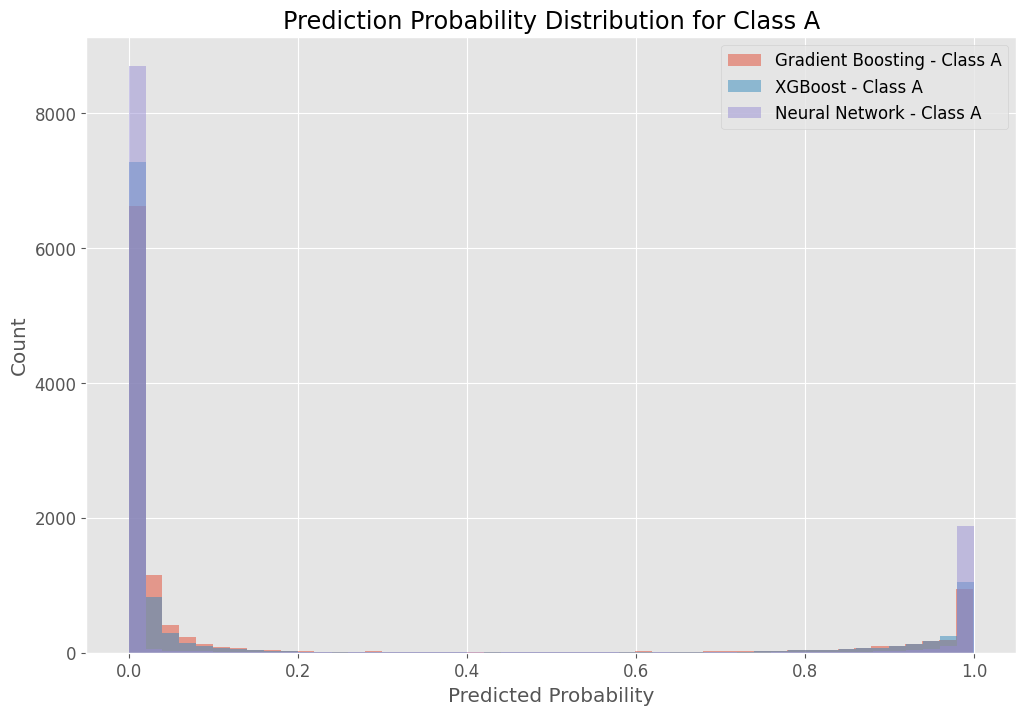

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
# Replace the import from scipy
# from scipy import interp
import numpy as np
# Import interp from numpy
from numpy import interp


# Set up plot style
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 8)})

# Binarize the output for ROC/PR curves
y_test_bin = label_binarize(y_test, classes=np.unique(y_res))
n_classes = y_test_bin.shape[1]

# 1. Confusion Matrices for All Models
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.flatten()

for i, (name, result) in enumerate(results.items()):
    if name == "Neural Network":
        y_pred = y_pred_nn
    else:
        y_pred = result['model'].predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300)
plt.show()

# 2. ROC Curves (One-vs-Rest)
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']

for model_name in ['Gradient Boosting', 'XGBoost', 'Neural Network']:
    model = results[model_name]['model']

    if model_name == "Neural Network":
        y_score = nn_model.predict(X_test)
    else:
        y_score = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'{model_name} (AUC = {roc_auc["macro"]:.2f})',
             color=colors[['Gradient Boosting', 'XGBoost', 'Neural Network'].index(model_name)],
             linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve Comparison')
plt.legend(loc="lower right")
plt.savefig('roc_comparison.png', dpi=300)
plt.show()

# 3. Precision-Recall Curves
plt.figure(figsize=(10, 8))
for model_name in ['Gradient Boosting', 'XGBoost', 'Neural Network']:
    model = results[model_name]['model']

    if model_name == "Neural Network":
        y_score = nn_model.predict(X_test)
    else:
        y_score = model.predict_proba(X_test)

    # For each class
    precision = dict()
    recall = dict()
    avg_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # Macro-average
    precision["macro"], recall["macro"], _ = precision_recall_curve(
        y_test_bin.ravel(), y_score.ravel())
    avg_precision["macro"] = average_precision_score(y_test_bin, y_score, average="macro")

    # Plot
    plt.plot(recall["macro"], precision["macro"],
             label=f'{model_name} (AP = {avg_precision["macro"]:.2f})',
             color=colors[['Gradient Boosting', 'XGBoost', 'Neural Network'].index(model_name)],
             linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Macro-average Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('pr_comparison.png', dpi=300)
plt.show()

# 4. Feature Importance for Tree-based Models
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, model_name in enumerate(['Random Forest', 'Gradient Boosting', 'XGBoost', 'Decision Tree']):
    if model_name in results:
        model = results[model_name]['model']

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1][:15]  # Top 15 features

            # Get feature names (PCA components)
            feature_names = [f'PC{i}' for i in range(X_pca.shape[1])]

            # Plot
            ax = axes[i]
            ax.barh(range(len(indices)), importances[indices][::-1], align='center')
            ax.set_yticks(range(len(indices)))
            ax.set_yticklabels([feature_names[idx] for idx in indices[::-1]])
            ax.set_title(f'{model_name} - Top 15 Features')
            ax.set_xlabel('Importance Score')

plt.tight_layout()
plt.savefig('feature_importances.png', dpi=300)
plt.show()

# 5. Learning Curves for Best Performing Model
from sklearn.model_selection import learning_curve

best_model_name = model_comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']

# Only for non-NN models
if best_model_name != "Neural Network":
    train_sizes, train_scores, test_scores = learning_curve(
        best_model, X_pca, y_res, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation Accuracy')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

    plt.title(f'{best_model_name} Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('learning_curve.png', dpi=300)
    plt.show()

# 6. Calibration Curves
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 8))
for model_name in ['Gradient Boosting', 'XGBoost', 'Neural Network']:
    model = results[model_name]['model']

    if model_name == "Neural Network":
        prob_pos = nn_model.predict(X_test)[:, 1]
    else:
        prob_pos = model.predict_proba(X_test)[:, 1]  # Using class 1 as example

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test_bin[:, 1], prob_pos, n_bins=10, strategy='quantile')

    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
             label=f'{model_name}')

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.xlabel('Mean predicted value')
plt.ylim([-0.05, 1.05])
plt.title('Calibration Curves (Class B)')
plt.legend()
plt.grid(True)
plt.savefig('calibration_curve.png', dpi=300)
plt.show()

# 7. Class Prediction Distribution
plt.figure(figsize=(12, 8))
for model_name in ['Gradient Boosting', 'XGBoost', 'Neural Network']:
    model = results[model_name]['model']

    if model_name == "Neural Network":
        y_proba = nn_model.predict(X_test)
    else:
        y_proba = model.predict_proba(X_test)

    # Plot for class 0 (A)
    plt.hist(y_proba[:, 0], bins=50, alpha=0.5,
             label=f'{model_name} - Class A')

plt.title('Prediction Probability Distribution for Class A')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig('probability_distribution.png', dpi=300)
plt.show()

349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


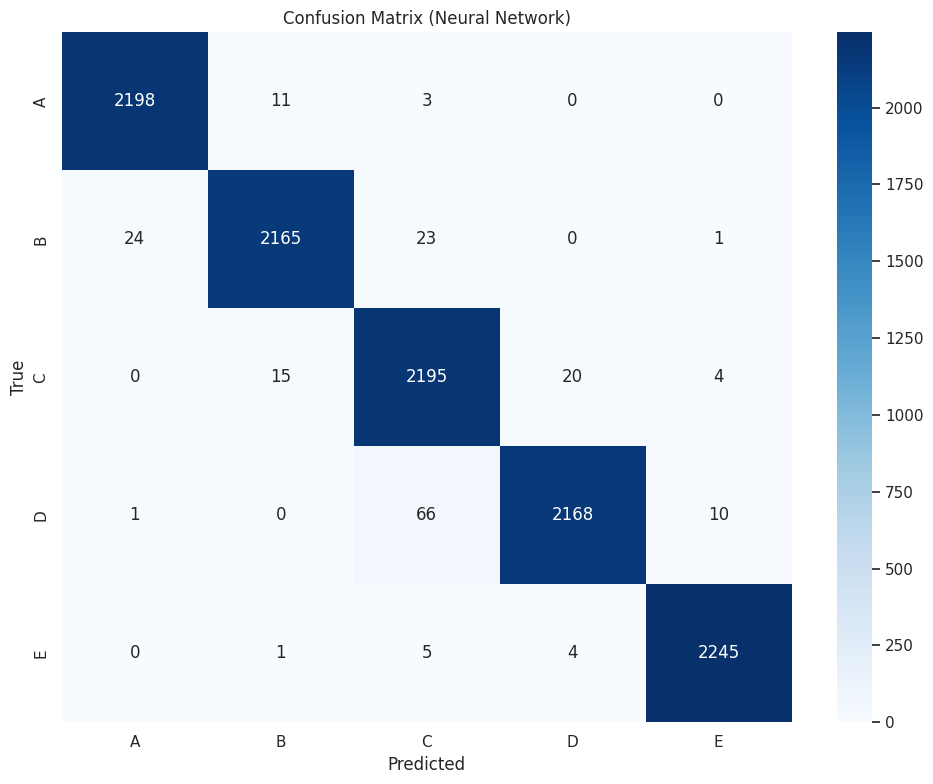

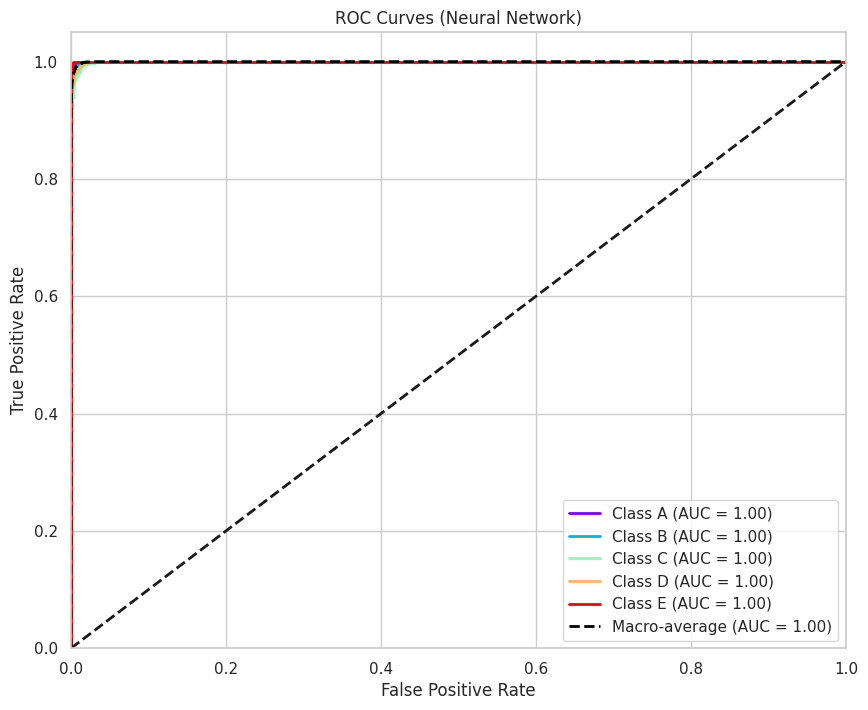

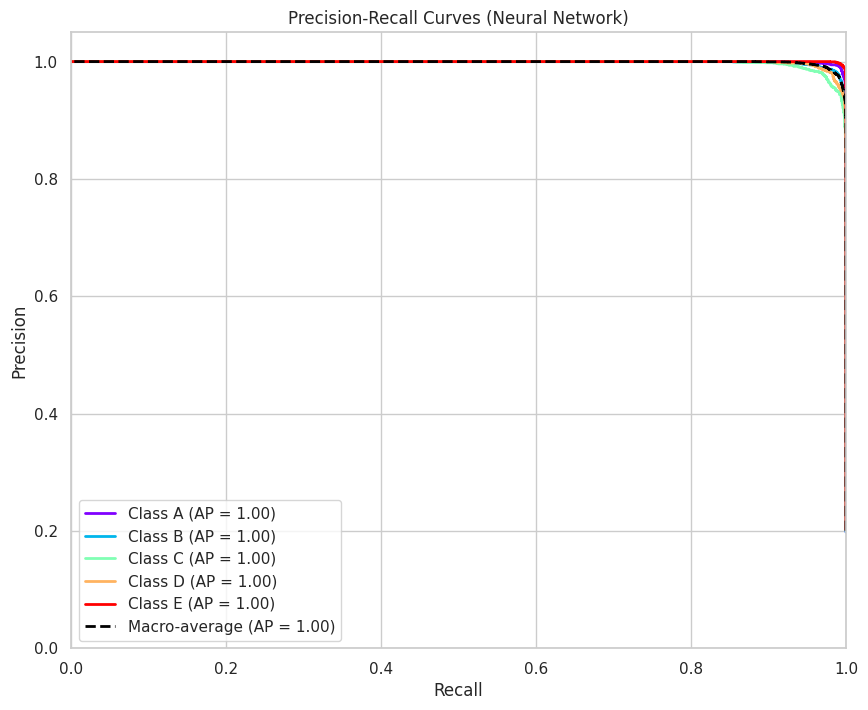

Skipping Feature Importance plot for Neural Network as it does not have 'feature_importances_'.
Skipping Learning Curve plot for Neural Network as it is a Neural Network (use history object instead).


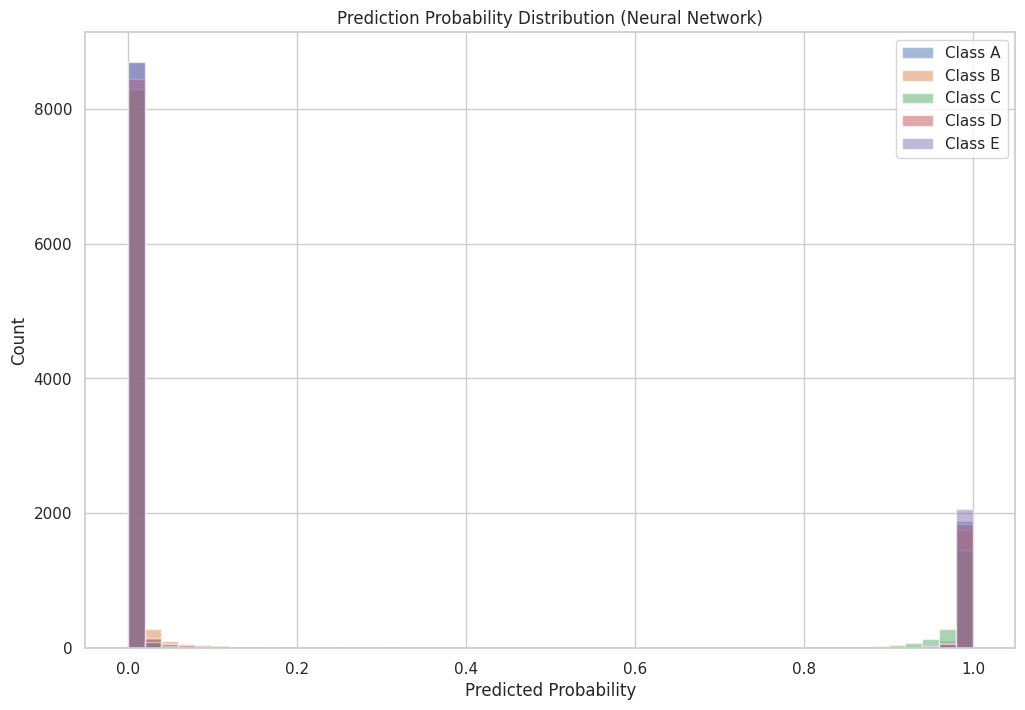

In [ ]:
# Fix import error by using numpy's interp instead of scipy's
import numpy as np
from numpy import interp
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Set plot style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 8)})

# Binarize the output for ROC/PR curves
y_test_bin = label_binarize(y_test, classes=np.unique(y_res))
n_classes = y_test_bin.shape[1]

# 1. Confusion Matrix for Best Model
plt.figure(figsize=(10, 8))

# Get the predictions based on the best model type
if best_model_name == "Neural Network":
    # For Neural Network, predict_proba is the standard predict method
    y_score = nn_model.predict(X_test)
    # Convert continuous probability predictions to discrete class labels for confusion matrix
    y_pred_best_model = np.argmax(y_score, axis=1)
else:
    # For other models, use predict directly for class labels
    y_pred_best_model = best_result['model'].predict(X_test)
    # For models with predict_proba, get scores for ROC/PR
    if hasattr(best_model, 'predict_proba'):
         y_score = best_model.predict_proba(X_test)
    else:
         # Handle models without predict_proba if necessary (e.g., some SVM kernels)
         # For simplicity, we assume models used here have predict_proba or are NN
         # You might need a different approach for models without probability output
         y_score = None # Or handle appropriately


cm = confusion_matrix(y_test, y_pred_best_model) # Use the discrete predictions here

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title(f'Confusion Matrix ({best_model_name})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('best_model_confusion_matrix.png', dpi=300)
plt.show()

# 2. ROC Curves for Best Model
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

# Ensure y_score is available for ROC/PR curves
if y_score is not None:
    # Plot ROC for each class
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'Class {le.classes_[i]} (AUC = {roc_auc:.2f})')

    # Plot macro-average ROC
    fpr_macro, tpr_macro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro, tpr_macro, color='black', linestyle='--', lw=2,
             label=f'Macro-average (AUC = {roc_auc_macro:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({best_model_name})')
    plt.legend(loc="lower right")
    plt.savefig('best_model_roc_curves.png', dpi=300)
    plt.show()
else:
    print(f"Skipping ROC curves for {best_model_name} as probability scores are not available.")


# 3. Precision-Recall Curves for Best Model
plt.figure(figsize=(10, 8))

# Ensure y_score is available for ROC/PR curves
if y_score is not None:
    # Plot PR for each class
    for i, color in zip(range(n_classes), colors):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, color=color, lw=2,
                 label=f'Class {le.classes_[i]} (AP = {avg_precision:.2f})')

    # Plot macro-average PR
    precision_macro, recall_macro, _ = precision_recall_curve(
        y_test_bin.ravel(), y_score.ravel())
    avg_precision_macro = average_precision_score(y_test_bin, y_score, average="macro")
    plt.plot(recall_macro, precision_macro, color='black', linestyle='--', lw=2,
             label=f'Macro-average (AP = {avg_precision_macro:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curves ({best_model_name})')
    plt.legend(loc="lower left")
    plt.savefig('best_model_pr_curves.png', dpi=300)
    plt.show()
else:
     print(f"Skipping Precision-Recall curves for {best_model_name} as probability scores are not available.")

# 4. Feature Importance for Best Model (if applicable)
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-15:]  # Top 15 features
    feature_names = [f'PC{i}' for i in range(X_pca.shape[1])]

    plt.title(f'Feature Importances ({best_model_name})')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('best_model_feature_importances.png', dpi=300)
    plt.show()
else:
    print(f"Skipping Feature Importance plot for {best_model_name} as it does not have 'feature_importances_'.")


# 5. Learning Curve for Best Model
from sklearn.model_selection import learning_curve

if best_model_name != "Neural Network":
    train_sizes, train_scores, test_scores = learning_curve(
        best_model, X_pca, y_res, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation Accuracy')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

    plt.title(f'{best_model_name} Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('best_model_learning_curve.png', dpi=300)
    plt.show()
else:
    print(f"Skipping Learning Curve plot for {best_model_name} as it is a Neural Network (use history object instead).")


# 6. Class Prediction Distribution
plt.figure(figsize=(12, 8))
# Ensure y_score is available for plotting distribution
if y_score is not None:
    for i in range(n_classes):
        plt.hist(y_score[:, i], bins=50, alpha=0.5,
                 label=f'Class {le.classes_[i]}')

    plt.title(f'Prediction Probability Distribution ({best_model_name})')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.savefig('best_model_probability_distribution.png', dpi=300)
    plt.show()
else:
     print(f"Skipping Prediction Probability Distribution plot for {best_model_name} as probability scores are not available.")